## Task 3: Warping images by composing rigid transformations

Implement a class RigidTransform which should specify a 3D rigid transformation which can wrap 3D image volumes. All units should be in voxel

- A class __init__ function which takes a set of 6 rigid transformations parameters, as input. Precompute a rotation matrix and a translation vector and stored in the returned class object.

In [1]:
import numpy as np

In [2]:
class RigidTransform:

    # Initialize class
    def __init__(self, rotations, translations):
        self.rx = rotations[0]
        self.ry = rotations[1]
        self.rz = rotations[2]
        self.tx = translations[0]
        self.ty = translations[1]
        self.tz = translations[2]

        # Precompute rotation matrices around the X, Y, and Z axis
        rot_x = np.array([[1, 0, 0],
                                 [0, np.cos(self.rx), -np.sin(self.rx)],
                                 [0, np.sin(self.rx), np.cos(self.rx)]])
                                 
        rot_y = np.array([[np.cos(self.ry), 0, np.sin(self.ry)],
                                [0, 1, 0],
                                [-np.sin(self.ry), 0, np.cos(self.ry)]])

        rot_z = np.array([[np.cos(self.rz), -np.sin(self.rz), 0],
                                [np.sin(self.rz), np.cos(self.rz), 0],
                                [0, 0, 1]])

        # Compose rotation matrix from yaw, pitch, and roll 
        # Correct order is Z, Y, X
        self.rot_vec = np.matmul(rot_z, np.matmul(rot_y, rot_x))

        # Compose translation vector
        self.trans_vec = np.array([self.tx, self.ty, self.tz])
        
        

In [3]:
import numpy as np

class RigidTransform:
    def __init__(self, rx, ry, rz, tx, ty, tz):
        self.rx = rx
        self.ry = ry
        self.rz = rz
        self.tx = tx
        self.ty = ty
        self.tz = tz
        
        # Precompute rotation matrix
        R_x = np.array([[1, 0, 0],
                        [0, np.cos(rx), -np.sin(rx)],
                        [0, np.sin(rx), np.cos(rx)]])
        R_y = np.array([[np.cos(ry), 0, np.sin(ry)],
                        [0, 1, 0],
                        [-np.sin(ry), 0, np.cos(ry)]])
        R_z = np.array([[np.cos(rz), -np.sin(rz), 0],
                        [np.sin(rz), np.cos(rz), 0],
                        [0, 0, 1]])
        self.R = np.matmul(R_z, np.matmul(R_y, R_x))
        
        # Precompute translation vector
        self.T = np.array([tx, ty, tz])
        
    def apply(self, volume):
        # Apply rotation and translation to the input volume
        return np.matmul(volume, self.R) + self.T


We are computing three separate rotation matrices (R_x, R_y, R_z) to represent the rotations around the x, y, and z axes, respectively. Each rotation matrix is responsible for a single rotation, and the final rotation matrix R is computed by multiplying the three rotation matrices in a specific order (R_zR_yR_x). This is known as the "Z-Y-X Euler angle convention", which means we rotate around the z-axis first, then the y-axis, and finally the x-axis.

This is a common way to represent a 3D rotation, where multiple rotations around different axes are combined into a single rotation matrix. By decomposing the rotation into three separate rotations, it becomes easier to specify the rotations in a more intuitive way, and it allows for more flexibility when applying the rotations.

In other words, the order of the rotations is important, and each rotation matrix is a representation of a rotation around a certain axis (x,y,z) and that is the reason we are computing three rotation matrixes.

The translation vector is computed by simply creating a 1-D array of the translation parameters tx, ty, and tz.
This vector is added to every point of the image volume after the rotation matrix has been applied.

The translation vector is simply the array [tx, ty, tz], which represents the translation along the x, y, and z axes, respectively in voxels. This vector is added to the final output of the transformed volume, the idea is that it shifts the entire transformed volume by the specified amount.

The translation vector is represented by a 1-D array because it is a vector quantity and it is a 1-D array because it only has one dimension and it is a vector of size 3(x,y,z) which corresponds to the 3D space.

## Class member function compute ddf that defines a 3D displacement vector

In [4]:
class RigidTransform:

    # Initialize class
    def __init__(self, rotations, translations):
        self.rx = rotations[0]
        self.ry = rotations[1]
        self.rz = rotations[2]
        self.tx = translations[0]
        self.ty = translations[1]
        self.tz = translations[2]

        # Precompute rotation matrices around the X, Y, and Z axis
        rot_x = np.array([[1, 0, 0],
                                 [0, np.cos(self.rx), -np.sin(self.rx)],
                                 [0, np.sin(self.rx), np.cos(self.rx)]])
                                 
        rot_y = np.array([[np.cos(self.ry), 0, np.sin(self.ry)],
                                [0, 1, 0],
                                [-np.sin(self.ry), 0, np.cos(self.ry)]])

        rot_z = np.array([[np.cos(self.rz), -np.sin(self.rz), 0],
                                [np.sin(self.rz), np.cos(self.rz), 0],
                                [0, 0, 1]])

        # Compose rotation matrix from yaw, pitch, and roll 
        # Correct order is Z, Y, X
        self.rot_vec = np.matmul(rot_z, np.matmul(rot_y, rot_x))

        # Compose translation vector
        self.trans_vec = np.array([self.tx, self.ty, self.tz])

        # Precompute the dense displacement field DDF
        self.ddf = self.compute_ddf((self.warped_image_size_x, self.warped_image_size_y, self.warped_image_size_z))

    # Implement a class member function compute_ddf that computes displacement vector
    # this code takes a point in the warped image,
    # undo the translation by subtracting the translation vector from the point,
    # then undo the rotation by applying the inverse rotation matrix, 
    # and the result is the displacement vector from the warped image to the original image
    #  at that voxel location.
    def compute_ddf(self, warped_image_size):
        # Compute displacement vector
        self.warped_image_size_x, self.warped_image_size_y, self.warped_image_size_z = warped_image_size
            # Pre-allocate displacement vector
        self.ddf = np.zeros((self.warped_image_size_x, self.warped_image_size_y, self.warped_image_size_z, 3))

        for x in range(self.warped_image_size_x):
            for y in range(self.warped_image_size_y):
                for z in range(self.warped_image_size_z):
                    # Compute displacement vector at each voxel
                    self.ddf[x, y, z, :] = np.matmul(np.linalg.inv(self.rot_vec), np.array([x, y, z]) - self.trans_vec)




        
        

In [3]:
a, b, c = (1, 2, 3); print(a, b, c)

1 2 3


In [2]:
np.zeros((1, 2, 3, 3))

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]])

The image coordinate system used in the above function is the standard Cartesian coordinate system, in which the origin is located at the center of the image, the x-axis is oriented from left to right, the y-axis is oriented from top to bottom, and the z-axis is oriented from front to back. The unit used is voxel, which means that the distance between two adjacent voxels is 1 in all three dimensions (x, y, z).

This coordinate system is consistent for both the warped image and the original image, meaning that the coordinates of the voxels in both images are defined in the same way. The origin of the coordinate system is located at the center of the image, which makes it easy to apply rotations and translations to the image while maintaining the same consistent coordinate system.

The orientation of the axis is also consistent, meaning that the x-axis is oriented from left to right, the y-axis is oriented from top to bottom, and the z-axis is oriented from front to back in both images. This makes it easy to understand the displacement vectors computed by the DDF, as the displacement values along each axis correspond to the standard x, y, and z axes.

In summary, the image coordinate system used in the above function is a standard Cartesian coordinate system with the origin located at the center of the image, the x-axis oriented from left to right, the y-axis oriented from top to bottom, and the z-axis oriented from front to back. The unit used is voxel, which is consistent for both the warped image and the original image.

## Class member function warp which returns a warped image volume in a numpy array

In [2]:
import numpy as np
from scipy.interpolate import interpn
from scipy.ndimage import map_coordinates
class RigidTransform:

    # Initialize class
    def __init__(self, rotations, translations, warped_image_size):
        self.rx = rotations[0]
        self.ry = rotations[1]
        self.rz = rotations[2]
        self.tx = translations[0]
        self.ty = translations[1]
        self.tz = translations[2]
        self.warped_image_size_x = warped_image_size[0]
        self.warped_image_size_y = warped_image_size[1]
        self.warped_image_size_z = warped_image_size[2]

        # Precompute rotation matrices around the X, Y, and Z axis
        rot_x = np.array([[1, 0, 0],
                                 [0, np.cos(self.rx), -np.sin(self.rx)],
                                 [0, np.sin(self.rx), np.cos(self.rx)]])
                                 
        rot_y = np.array([[np.cos(self.ry), 0, np.sin(self.ry)],
                                [0, 1, 0],
                                [-np.sin(self.ry), 0, np.cos(self.ry)]])

        rot_z = np.array([[np.cos(self.rz), -np.sin(self.rz), 0],
                                [np.sin(self.rz), np.cos(self.rz), 0],
                                [0, 0, 1]])

        # Compose rotation matrix from yaw, pitch, and roll 
        # Correct order is Z, Y, X
        self.rot_vec = np.matmul(rot_z, np.matmul(rot_y, rot_x))

        # Compose translation vector
        self.trans_vec = np.array([self.tx, self.ty, self.tz])

        # Precompute the dense displacement field DDF
        #self.ddf = self.compute_ddf((self.warped_image_size_x, self.warped_image_size_y, self.warped_image_size_z))
        self.compute_ddf((self.warped_image_size_x, self.warped_image_size_y, self.warped_image_size_z))

    # Implement a class member function compute_ddf that computes displacement vector
    # this code takes a point in the warped image,
    # undo the translation by subtracting the translation vector from the point,
    # then undo the rotation by applying the inverse rotation matrix, 
    # and the result is the displacement vector from the warped image to the original image
    #  at that voxel location.
    def compute_ddf(self, warped_image_size):
        # Compute displacement vector
        self.warped_image_size_x, self.warped_image_size_y, self.warped_image_size_z = warped_image_size
            # Pre-allocate displacement vector
        self.ddf = np.zeros((self.warped_image_size_x, self.warped_image_size_y, self.warped_image_size_z, 3))

        for x in range(self.warped_image_size_x):
            for y in range(self.warped_image_size_y):
                for z in range(self.warped_image_size_z):
                    # Compute displacement vector at each voxel
                    self.ddf[x, y, z, :] = np.matmul(np.linalg.inv(self.rot_vec), np.array([x, y, z]) - self.trans_vec)


    # Implement a class member function warp that returns a warped image volume in a Numpy Array
    def warp(self, volume):
        # Pre-allocate warped volume
        warped_image_coords = []
        #warped_volume = np.zeros_like(volume)
        for x in range(volume.shape[0]):
            for y in range(volume.shape[1]):
                for z in range(volume.shape[2]):
                    # Compute new voxel coordinates in the warped image
                    warped_image_coords.append(np.matmul(self.rot_vec, np.array([x, y, z])) + self.trans_vec)
        warped_image_coords = np.array(warped_image_coords)

        # Resample intensity values at the new coordinates
        #warped_volume[x, y, z] = interpn(np.array([x, y, z], ), volume, np.array((new_x, new_y, new_z),), method = 'linear', bounds_error = False, fill_value = None)
        
        warped_volume = map_coordinates(volume, [warped_image_coords.T[0], warped_image_coords.T[1], warped_image_coords.T[2]], order=1, mode='nearest')
        warped_volume = warped_volume.reshape(volume.shape)
        return warped_volume

    # Implement a class member function compose which represents a combination of two transforms
    def compose(self, rotations2, translations2):

        composed_transform = RigidTransform(rotations2, translations2,  warped_image_size = (128, 128, 32))

        # Update rotation matrix
        composed_transform.rot_vec = np.matmul(self.rot_vec, composed_transform.rot_vec)

        # Update translation vector
        composed_transform.trans_vec = np.matmul(self.rot_vec, np.array(translations2)) + self.trans_vec

        # Update the displacement field
        composed_transform.compute_ddf((self.warped_image_size_x, self.warped_image_size_y, self.warped_image_size_z))

        # # Compute the combined rotation matrix
        # rot_x2 = np.array([[1, 0, 0],
        #                     [0, np.cos(rotations2[0]), -np.sin(rotations2[0])],
        #                     [0, np.sin(rotations2[0]), np.cos(rotations2[0])]])

        # rot_y2 = np.array([[np.cos(rotations2[1]), 0, np.sin(rotations2[1])],
        #                     [0, 1, 0],
        #                     [-np.sin(rotations2[1]), 0, np.cos(rotations2[1])]])

        # rot_z2 = np.array([[np.cos(rotations2[2]), -np.sin(rotations2[2]), 0],
        #                     [np.sin(rotations2[2]), np.cos(rotations2[2]), 0],
        #                     [0, 0, 1]])

        # # Compose rotation matrix from yaw, pitch, and roll 
        # # Correct order is Z, Y, X
        # rot_vec2 = np.matmul(rot_z2, np.matmul(rot_y2, rot_x2))
        # R_composed = np.matmul(self.rot_vec, rot_vec2)

        
        # # Compute the combined translation vector
        # #T_composed = np.matmul(self.rot_vec, np.array(translations2)) + self.trans_vec
        # T_composed = np.matmul(self.rot_vec, self.trans_vec) + np.array(translations2)

        # # Create a new RigidTransform object with the composed transformations
        # composed_transform = RigidTransform(R_composed, T_composed)

        # # Update the displacement field
        # composed_transform.compute_ddf((self.warped_image_size_x, self.warped_image_size_y, self.warped_image_size_z))

        return composed_transform
        
        
                    

### Test the composed transformations

Manually define the ranges of translation and rotation parameters, according to the coordinate system defined in `RigidTransform` class.

-1000 to 1000 voxels which allows for translations up to 1000 voxels in any direction. For rotation, -180 to 180, to allow for rotations of up to 180 degrees in any direction


In [3]:
# Load image train 00
volume = np.load('image_train00.npy').T
# Define translation and rotation parameters
rotations = np.array([30, 90, 150])*np.pi/180
translations = np.array([10, 20, 30])

In [5]:
rotations2 = np.array([60, 90, 120])*np.pi/180
translations2 = np.array([11, 21, 31])

rot_x2 = np.array([[1, 0, 0],
                            [0, np.cos(rotations2[0]), -np.sin(rotations2[0])],
                            [0, np.sin(rotations2[0]), np.cos(rotations2[0])]])

rot_y2 = np.array([[np.cos(rotations2[1]), 0, np.sin(rotations2[1])],
                            [0, 1, 0],
                            [-np.sin(rotations2[1]), 0, np.cos(rotations2[1])]])

rot_z2 = np.array([[np.cos(rotations2[2]), -np.sin(rotations2[2]), 0],
                            [np.sin(rotations2[2]), np.cos(rotations2[2]), 0],
                            [0, 0, 1]])
# Compose rotation matrix from yaw, pitch, and roll 
        # Correct order is Z, Y, X
rot_vec2 = np.matmul(rot_z2, np.matmul(rot_y2, rot_x2))
R_composed = np.matmul(rigid_transform.rot_vec, rot_vec2)

T_composed = np.matmul(rigid_transform.rot_vec, np.array(translations2)) + rigid_transform.trans_vec

In [11]:
R_composed


array([[ 5.00000000e-01, -4.33012702e-01, -7.50000000e-01],
       [-8.66025404e-01, -2.50000000e-01, -4.33012702e-01],
       [-2.24125920e-17,  8.66025404e-01, -5.00000000e-01]])

In [8]:
rigid_transform2 = rigid_transform.compose(rotations2, translations2)

In [12]:
rigid_transform2.rot_vec

array([[ 5.00000000e-01, -4.33012702e-01, -7.50000000e-01],
       [-8.66025404e-01, -2.50000000e-01, -4.33012702e-01],
       [-2.24125920e-17,  8.66025404e-01, -5.00000000e-01]])

In [13]:
ddf = np.zeros((128, 128, 32, 3))

for x in range(128):
    for y in range(128):
        for z in range(32):
            # Compute displacement vector at each voxel
            ddf[x, y, z, :] = np.matmul(np.linalg.inv(R_composed), np.array([x, y, z]) - T_composed)
ddf[15, 124, 31, :] == rigid_transform2.ddf[15, 124, 31, :]

In [4]:
rigid_transform = RigidTransform(rotations = rotations, translations = translations, warped_image_size = (128, 128, 32))

In [9]:
rigid_transform.rot_vec

array([[-5.30287619e-17, -8.66025404e-01, -5.00000000e-01],
       [ 3.06161700e-17, -5.00000000e-01,  8.66025404e-01],
       [-1.00000000e+00,  3.06161700e-17,  5.30287619e-17]])

In [ ]:
ddf = np.zeros(volume.shape)

for x in range(rigid_transform.warped_image_size_x):
    for y in range(rigid_transform.warped_image_size_y):
        for z in range(rigid_transform.warped_image_size_z):
            # Compute displacement vector at each voxel
            rigid_transform.ddf[x, y, z, :] = np.matmul(np.linalg.inv(rigid_transform.rot_vec), np.array([x, y, z]) - rigid_transform.trans_vec)

In [ ]:
np.matmul(np.linalg.inv(rigid_transform.rot_vec), np.array([0, 0, 0]) - rigid_transform.trans_vec)

In [13]:
rigid_transform.ddf.size

1572864

In [15]:
128*128*32*3

1572864

In [16]:
volume.size

524288

In [8]:
warped_volume = np.zeros_like(volume)
warped_volume.shape

(128, 128, 32)

In [29]:
warped_image_coords = []
for x in range(volume.shape[0]):
            for y in range(volume.shape[1]):
                for z in range(volume.shape[2]):
                    # Compute new voxel coordinates in the warped image
                    warped_image_coords.append([np.matmul(rigid_transform.rot_vec, np.array([x, y, z])) + rigid_transform.trans_vec])
                    #warped_image_coords.append([x, y, z])


In [30]:
warped_image_coords = np.array(warped_image_coords)
warped_image_coords.shape

(524288, 1, 3)

In [52]:
warped_image_coords.T

array([[[  10.        ,    9.5       ,    9.        , ...,
         -114.48522628, -114.98522628, -115.48522628]],

       [[  20.        ,   20.8660254 ,   21.73205081, ...,
          -18.38526329,  -17.51923789,  -16.65321248]],

       [[  30.        ,   30.        ,   30.        , ...,
          -97.        ,  -97.        ,  -97.        ]]])

In [ ]:
warped_image_coords.shape

In [43]:
np.array(warped_image_coords).reshape(128, 128,-1).shape

(128, 128, 96)

In [44]:
warped_image_coords = warped_image_coords.reshape(128, 128, 32, 3)

In [45]:
warped_image_coords[:, :, :, 2]

array([[[ 30.,  30.,  30., ...,  30.,  30.,  30.],
        [ 30.,  30.,  30., ...,  30.,  30.,  30.],
        [ 30.,  30.,  30., ...,  30.,  30.,  30.],
        ...,
        [ 30.,  30.,  30., ...,  30.,  30.,  30.],
        [ 30.,  30.,  30., ...,  30.,  30.,  30.],
        [ 30.,  30.,  30., ...,  30.,  30.,  30.]],

       [[ 29.,  29.,  29., ...,  29.,  29.,  29.],
        [ 29.,  29.,  29., ...,  29.,  29.,  29.],
        [ 29.,  29.,  29., ...,  29.,  29.,  29.],
        ...,
        [ 29.,  29.,  29., ...,  29.,  29.,  29.],
        [ 29.,  29.,  29., ...,  29.,  29.,  29.],
        [ 29.,  29.,  29., ...,  29.,  29.,  29.]],

       [[ 28.,  28.,  28., ...,  28.,  28.,  28.],
        [ 28.,  28.,  28., ...,  28.,  28.,  28.],
        [ 28.,  28.,  28., ...,  28.,  28.,  28.],
        ...,
        [ 28.,  28.,  28., ...,  28.,  28.,  28.],
        [ 28.,  28.,  28., ...,  28.,  28.,  28.],
        [ 28.,  28.,  28., ...,  28.,  28.,  28.]],

       ...,

       [[-95., -95., -95

In [ ]:
np.unique(np.vstack((warped_image_coords[:, :, :, 0].flatten(), warped_image_coords[:, :, :, 1].flatten(), warped_image_coords[:, :, :, 2].flatten()))[2]).shape

In [36]:
volume.shape

(128, 128, 32)

In [15]:
p=interpn((np.arange(volume.shape[0]), np.arange(volume.shape[1]), np.arange(volume.shape[2])),
volume, warped_image_coords,
method = 'linear', bounds_error = False,
fill_value = None)
p.shape

(524288, 1)

In [19]:
p = p.reshape(128, 128, -1)

In [20]:
p.shape

(128, 128, 32)

In [52]:
warped_volume = np.zeros_like(volume)
warped_volume.shape

(128, 128, 32)

In [59]:
warped_volume = np.zeros_like(volume)
for x in range(volume.shape[0]):
    for y in range(volume.shape[1]):
        for z in range(volume.shape[2]):
            # Compute new voxle coordinates in the warped image
            new_x, new_y, new_z = np.matmul(rigid_transform.rot_vec, np.array([x, y, z])) + rigid_transform.trans_vec

            # Resample intensity values at the new coordinates
            warped_volume[x, y, z] = interpn((np.arange(volume.shape[0]), np.arange(volume.shape[1]), np.arange(volume.shape[2])), volume, np.array((new_x, new_y, new_z),), method = 'linear', bounds_error = False, fill_value = 0)

In [22]:
warped_volume = []
for x in range(volume.shape[0]):
    for y in range(volume.shape[1]):
        for z in range(volume.shape[2]):
            # Compute new voxle coordinates in the warped image
            warped_volume.append(np.matmul(rigid_transform.rot_vec, np.array([x, y, z])) + rigid_transform.trans_vec)

In [24]:
warped_volume = np.array(warped_volume)
warped_volume.shape

(524288, 3)

In [26]:
warped_volume = warped_volume.reshape(128, 128, -1)

In [27]:
warped_volume.shape

(128, 128, 96)

In [41]:
warped_image_coords.T[0]

IndexError: index 1 is out of bounds for axis 0 with size 1

In [44]:
128*128*32

524288

In [45]:
from scipy.ndimage import map_coordinates
new_vol = map_coordinates(volume, [warped_image_coords.T[0], warped_image_coords.T[1], warped_image_coords.T[2]], order=1, mode='nearest')

In [47]:
new_vol = new_vol.reshape(128, 128, 32)

In [81]:
interpn((x_coords, y_coords, z_coords), volume, np.array((new_x, new_y, new_z)), method = 'linear', bounds_error = False, fill_value = 0)

ValueError: The points in dimension 0 must be strictly ascending or descending

In [73]:
warped_volume

array([[[ 98, 113, 102, ...,   0,   0,   0],
        [103, 107, 122, ...,   0,   0,   0],
        [ 98,  85, 111, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[117,  86, 107, ...,   0,   0,   0],
        [ 79,  86,  90, ...,   0,   0,   0],
        [107,  88,  97, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[105, 116,  95, ...,   0,   0,   0],
        [106, 117, 108, ...,   0,   0,   0],
        [ 96, 108,  95, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       ...,

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0

In [66]:
x_coords, y_coords, z_coords = np.mgrid[:volume.shape[0], :volume.shape[1], :volume.shape[2]]
voxel_coords=np.stack([x_coords, y_coords, z_coords], axis = -1)


In [80]:
(x_coords, y_coords, z_coords,)

(array([[[  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         ...,
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0]],
 
        [[  1,   1,   1, ...,   1,   1,   1],
         [  1,   1,   1, ...,   1,   1,   1],
         [  1,   1,   1, ...,   1,   1,   1],
         ...,
         [  1,   1,   1, ...,   1,   1,   1],
         [  1,   1,   1, ...,   1,   1,   1],
         [  1,   1,   1, ...,   1,   1,   1]],
 
        [[  2,   2,   2, ...,   2,   2,   2],
         [  2,   2,   2, ...,   2,   2,   2],
         [  2,   2,   2, ...,   2,   2,   2],
         ...,
         [  2,   2,   2, ...,   2,   2,   2],
         [  2,   2,   2, ...,   2,   2,   2],
         [  2,   2,   2, ...,   2,   2,   2]],
 
        ...,
 
        [[125, 125, 125, ..., 125, 125, 125],
         [125, 125, 125, ..., 125, 125, 125],
         [125,

In [70]:
voxel_coords

array([[[[  0,   0,   0],
         [  0,   0,   1],
         [  0,   0,   2],
         ...,
         [  0,   0,  29],
         [  0,   0,  30],
         [  0,   0,  31]],

        [[  0,   1,   0],
         [  0,   1,   1],
         [  0,   1,   2],
         ...,
         [  0,   1,  29],
         [  0,   1,  30],
         [  0,   1,  31]],

        [[  0,   2,   0],
         [  0,   2,   1],
         [  0,   2,   2],
         ...,
         [  0,   2,  29],
         [  0,   2,  30],
         [  0,   2,  31]],

        ...,

        [[  0, 125,   0],
         [  0, 125,   1],
         [  0, 125,   2],
         ...,
         [  0, 125,  29],
         [  0, 125,  30],
         [  0, 125,  31]],

        [[  0, 126,   0],
         [  0, 126,   1],
         [  0, 126,   2],
         ...,
         [  0, 126,  29],
         [  0, 126,  30],
         [  0, 126,  31]],

        [[  0, 127,   0],
         [  0, 127,   1],
         [  0, 127,   2],
         ...,
         [  0, 127,  29],
        

In [71]:
voxel_coords_n = np.matmul(rigid_transform.rot_vec, voxel_coords) + rigid_transform.trans_vec

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 32 is different from 3)

In [64]:
voxel_coords_n

array([-115.48522628,  -16.65321248,  -97.        ])

In [ ]:
for voxel in np.nditer(volume, order = 'C'):
    print(voxel)

In [54]:
np.matmul(rigid_transform.rot_vec, np.array([0, 0, 0])) + rigid_transform.trans_vec

array([10., 20., 30.])

In [18]:
warped_volume.reshape(128, 128, -1)

array([[[    98,    113,    102, ...,    163,    -36,    -20],
        [   103,    107,    122, ...,    135,     72,    -65],
        [    98,     85,    111, ...,     43,    206,    -58],
        ...,
        [  4314,   2233,    125, ...,  -1742,  -4627,  -7539],
        [  7096,   4999,   2875, ...,    576,  -2324,  -5252],
        [  9906,   7793,   5653, ...,   2922,      6,  -2939]],

       [[   117,     86,    107, ...,    108,    104,    195],
        [    79,     86,     90, ...,    135,     97,    138],
        [   107,     88,     97, ...,    185,     90,     86],
        ...,
        [-25894, -24550, -23187, ...,  20480,  22351,  24241],
        [-27743, -26388, -25015, ...,  18935,  20818,  22718],
        [-29610, -28245, -26861, ...,  17373,  19266,  21177]],

       [[   105,    116,     95, ...,     43,     86,     -5],
        [   106,    117,    108, ...,     41,     47,     36],
        [    96,    108,     95, ...,     58,      2,     60],
        ...,
        [-11

In [40]:
volume

array([[[ 54,  65,  92, ...,  55,  94,  70],
        [ 45,  66,  57, ...,  68,  64,  60],
        [ 79,  80,  74, ...,  85,  74,  75],
        ...,
        [ 53,  68,  65, ...,  53,  64,  61],
        [111,  76,  66, ...,  74,  84,  83],
        [ 75,  74,  58, ...,  49,  84,  49]],

       [[ 53,  66,  31, ...,  88,  90,  92],
        [102,  66,  87, ...,  80,  92, 106],
        [ 68,  64,  81, ...,  77,  89,  74],
        ...,
        [ 96,  85,  81, ...,  91,  68,  80],
        [ 71,  98,  89, ...,  76,  80,  98],
        [120,  75,  81, ...,  80,  54,  62]],

       [[ 97,  86,  83, ...,  99,  95,  82],
        [ 43,  89,  75, ..., 102,  96,  99],
        [ 61,  91,  51, ...,  58,  97,  89],
        ...,
        [109,  75,  86, ...,  69,  64,  65],
        [ 74,  75,  67, ...,  71,  80,  63],
        [141,  81,  57, ...,  86, 103, 102]],

       ...,

       [[ 85,  60,  59, ..., 153, 171,  98],
        [ 49,  64,  95, ..., 147, 151, 123],
        [112, 129, 195, ..., 143, 147,  78

In [48]:
warped_volume

array([[[    98,    113,    102, ...,    163,    -36,    -20],
        [   103,    107,    122, ...,    135,     72,    -65],
        [    98,     85,    111, ...,     43,    206,    -58],
        ...,
        [  4314,   2233,    125, ...,  -1742,  -4627,  -7539],
        [  7096,   4999,   2875, ...,    576,  -2324,  -5252],
        [  9906,   7793,   5653, ...,   2922,      6,  -2939]],

       [[   117,     86,    107, ...,    108,    104,    195],
        [    79,     86,     90, ...,    135,     97,    138],
        [   107,     88,     97, ...,    185,     90,     86],
        ...,
        [-25894, -24550, -23187, ...,  20480,  22351,  24241],
        [-27743, -26388, -25015, ...,  18935,  20818,  22718],
        [-29610, -28245, -26861, ...,  17373,  19266,  21177]],

       [[   105,    116,     95, ...,     43,     86,     -5],
        [   106,    117,    108, ...,     41,     47,     36],
        [    96,    108,     95, ...,     58,      2,     60],
        ...,
        [-11

Text(0.5, 1.0, 'Rescaled')

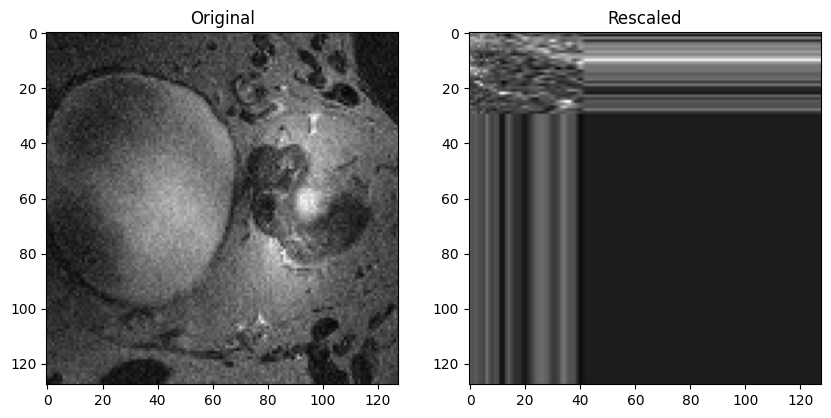

In [49]:
import matplotlib.pyplot as plt
# Visualize example slices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(volume[:,:,31], cmap='gray')
ax1.set_title('Original')
ax2.imshow(new_vol[:,:,1], cmap='gray')
ax2.set_title('Rescaled')

In [24]:
warped_image_coords = np.array(warped_image_coords)
warped_image_coords.shape

(524288, 1, 3)

In [36]:
warped_image_coords

ValueError: cannot reshape array of size 1572864 into shape (100,100,100)

In [8]:
# Warped image volume
warped_volume = rigid_transform.warp(volume)

ValueError: diff requires input that is at least one dimensional

In [17]:
rigid_transform.ddf.shape

(100, 100, 100, 3)

In [ ]:
# from scipy.interpolate import interpn
# class RigidTransform:

#     # Initialize class
#     def __init__(self, rotations, translations, warped_image_size):
#         self.rx = rotations[0]
#         self.ry = rotations[1]
#         self.rz = rotations[2]
#         self.tx = translations[0]
#         self.ty = translations[1]
#         self.tz = translations[2]
#         self.compute_ddf = lambda: None
#         self.warped_image_size_x = warped_image_size[0]
#         self.warped_image_size_y = warped_image_size[1]
#         self.warped_image_size_z = warped_image_size[2]

#         # Precompute rotation matrices around the X, Y, and Z axis
#         rot_x = np.array([[1, 0, 0],
#                                  [0, np.cos(self.rx), -np.sin(self.rx)],
#                                  [0, np.sin(self.rx), np.cos(self.rx)]])
                                 
#         rot_y = np.array([[np.cos(self.ry), 0, np.sin(self.ry)],
#                                 [0, 1, 0],
#                                 [-np.sin(self.ry), 0, np.cos(self.ry)]])

#         rot_z = np.array([[np.cos(self.rz), -np.sin(self.rz), 0],
#                                 [np.sin(self.rz), np.cos(self.rz), 0],
#                                 [0, 0, 1]])

#         # Compose rotation matrix from yaw, pitch, and roll 
#         # Correct order is Z, Y, X
#         self.rot_vec = np.matmul(rot_z, np.matmul(rot_y, rot_x))

#         # Compose translation vector
#         self.trans_vec = np.array([self.tx, self.ty, self.tz])

#         # Precompute the dense displacement field DDF
#         #self.ddf = self.compute_ddf((self.warped_image_size_x, self.warped_image_size_y, self.warped_image_size_z))
#     def __call__(self, warped_image_size):
#         self.compute_ddf(warped_image_size)

#     # Implement a class member function compute_ddf that computes displacement vector
#     # this code takes a point in the warped image,
#     # undo the translation by subtracting the translation vector from the point,
#     # then undo the rotation by applying the inverse rotation matrix, 
#     # and the result is the displacement vector from the warped image to the original image
#     #  at that voxel location.
#     def compute_ddf(self, warped_image_size):
#         # Compute displacement vector
#         self.warped_image_size_x, self.warped_image_size_y, self.warped_image_size_z = warped_image_size
#             # Pre-allocate displacement vector
#         self.ddf = np.zeros((self.warped_image_size_x, self.warped_image_size_y, self.warped_image_size_z, 3))

#         for x in range(self.warped_image_size_x):
#             for y in range(self.warped_image_size_y):
#                 for z in range(self.warped_image_size_z):
#                     # Compute displacement vector at each voxel
#                     self.ddf[x, y, z, :] = np.matmul(np.linalg.inv(self.rot_vec), np.array([x, y, z]) - self.trans_vec)


#     # Implement a class member function warp that returns a warped image volume in a Numpy Array
#     def warp(self, volume):
#         # Pre-allocate warped volume
#         warped_volume = np.zeros_like(volume)
#         for x in range(volume.shape[0]):
#             for y in range(volume.shape[1]):
#                 for z in range(volume.shape[2]):
#                     # Compute new voxle coordinates in the warped image
#                     new_x, new_y, new_z = np.matmul(self.rot_vec, np.array([x, y, z])) + self.trans_vec

#                     # Resample intensity values at the new coordinates
#                     warped_volume[x, y, z] = interpn(np.array([x, y, z], ), volume, np.array((new_x, new_y, new_z),), method = 'linear', bounds_error = False, fill_value = None)
#                     #warped_volume[x, y, z] = volume[new_x, new_y, new_z]

#         return warped_volume

#     # Implement a class member function compose which represents a combination of two transforms
#     def compose(self, rotations2, translations2):
#         # Compute the combined rotation matrix
#         rot_x2 = np.array([[1, 0, 0],
#                             [0, np.cos(rotations2[0]), -np.sin(rotations2[0])],
#                             [0, np.sin(rotations2[0]), np.cos(rotations2[0])]])

#         rot_y2 = np.array([[np.cos(rotations2[1]), 0, np.sin(rotations2[1])],
#                             [0, 1, 0],
#                             [-np.sin(rotations2[1]), 0, np.cos(rotations2[1])]])

#         rot_z2 = np.array([[np.cos(rotations2[2]), -np.sin(rotations2[2]), 0],
#                             [np.sin(rotations2[2]), np.cos(rotations2[2]), 0],
#                             [0, 0, 1]])

#         # Compose rotation matrix from yaw, pitch, and roll 
#         # Correct order is Z, Y, X
#         rot_vec2 = np.matmul(rot_z2, np.matmul(rot_y2, rot_x2))
#         R_composed = np.matmul(self.rot_vec, rot_vec2)

        
#         # Compute the combined translation vector
#         #T_composed = np.matmul(self.rot_vec, np.array(translations2)) + self.trans_vec
#         T_composed = np.matmul(self.rot_vec, self.trans_vec) + np.array(translations2)

#         # Create a new RigidTransform object with the composed transformations
#         composed_transform = RigidTransform(R_composed, T_composed)

#         # Update the displacement field
#         composed_transform.compute_ddf((self.warped_image_size_x, self.warped_image_size_y, self.warped_image_size_z))

#         return composed_transform
        
        
                    